In [99]:
import numpy as np
import pandas
from sdv import Metadata
from sdv.utils import display_tables
from sdv.relational import HMA1

## Import data

In [80]:
df_customers_raw = pandas.read_csv('../data/zurich_preprocessed/customer_data.csv')
df_policy_raw = pandas.read_csv('../data/zurich_preprocessed/policy_data.csv')
df_claim_raw = pandas.read_csv('../data/zurich_preprocessed/claim_data.csv')


/var/folders/49/54cg_t5s42n8wh70dkl1kdcr0000gn/T/ipykernel_19070/75372744.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_policy_raw = pandas.read_csv('../data/zurich_preprocessed/policy_data.csv')


In [81]:
# Filter data to only include data from 2021 onwards
df_policy = df_policy_raw[df_policy_raw['underwriting_date'] >= '2020-01-01']
df_policy = df_policy[df_policy['underwriting_date'] < '2020-01-02']
# sample 1000 rows from df_policy
df_policy = df_policy.sample(n=1000, random_state=1)

In [82]:
# keep rows in df_customers that are in df_policy
df_customers = df_customers_raw[df_customers_raw['customer_id'].isin(df_policy['customer_id'])]
# # convert date of birth to unix timestamp
# df_customers['date_of_birth'] = df_customers['date_of_birth'].apply(lambda x: pandas.to_datetime(x).timestamp() if not pandas.isnull(x) else x)

# keep rows in df_claim that are in df_policy
df_claim = df_claim_raw[df_claim_raw['policy_id'].isin(df_policy['policy_id'])]
# drop rows where claim_id is NaN
df_claim = df_claim.dropna(subset=['claim_id'])
df_claim = df_claim.dropna(subset=['customer_id'])
df_claim['customer_id'] = df_claim['customer_id'].astype(int)
df_claim['policy_id'] = df_claim['policy_id'].astype(int)

# drop rows in df_policy where customer_id is NaN
df_policy = df_policy.dropna(subset=['customer_id'])
# convert customer_id in df_policy to int
df_policy['customer_id'] = df_policy['customer_id'].astype(int)

In [83]:
len(df_claim)

162

## Create metadata data for SDV

In [84]:
tables = {}
tables['customers'] = df_customers
tables['policy'] = df_policy
tables['claim'] = df_claim

In [85]:
metadata = Metadata()

In [86]:
customer_fields_metadata = {
    'date_of_birth': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
}
metadata.add_table(
    name='customers',
    data=tables['customers'],
    primary_key='customer_id',
    fields_metadata=customer_fields_metadata,
)

In [87]:
df_policy.head()

,underwriting_date,first_end_date,cancellation_or_end_date,policy_id,sales_channel,customer_id,premium,status,line,product_name,product_group
14918736,2020-01-01,2021-01-01,NaN,14918736,13.0,2266813,357.0,active policy,General insurance,53.0,51.0
6627939,2020-01-01,2021-01-01,NaN,6627939,13.0,773192,173.0,active policy,General insurance,53.0,51.0
1380559,2020-01-01,NaN,NaN,1380559,0.0,212171,NaN,active policy,Life insurance,2.0,2.0
1381795,2020-01-01,NaN,NaN,1381795,4.0,212523,NaN,active policy,Life insurance,2.0,2.0
1379788,2020-01-01,NaN,NaN,1379788,0.0,49121,NaN,active policy,Life insurance,2.0,2.0


In [88]:
# add child table
policy_fields_metadata = {
    'underwriting_date': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
    'first_end_date': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
}

metadata.add_table(
    name='policy',
    data=tables['policy'],
    primary_key='policy_id',
    parent='customers',
    foreign_key='customer_id',
    fields_metadata=policy_fields_metadata,
)

In [89]:
df_claim

,claim_expense,claim_paid,claim_recovered,claim_reserved,claim_status,claim_total_value,date_closed,date_open,event_date,policy_id,claim_id,customer_id,total_insurance_expense
63362,0,0,0.0,116,open,116,NaN,2020-09-14,2020-08-16,12496720,63362,1832933,116.0
64033,69,252,0.0,46,settled,298,2020-12-14,2020-09-29,2020-09-25,10609818,64033,1494894,298.0
65614,156,2506,0.0,1500,partially settled,4006,NaN,2020-09-11,2020-02-20,14213680,65614,2141947,4006.0
65689,0,600,0.0,0,settled,600,2020-11-06,2020-11-06,2020-10-25,11698760,65689,1691630,600.0
66000,0,183,0.0,0,settled,183,2020-12-11,2020-10-16,2020-09-02,4383863,66000,372447,183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
710169,12,28,0.0,0,settled,28,2020-08-26,2020-08-26,2020-07-29,3487238,710169,212194,28.0
710170,0,46,0.0,0,settled,46,2020-11-04,2020-11-04,2020-10-06,3487238,710170,212194,46.0
710171,0,8,0.0,0,settled,8,2020-11-04,2020-11-04,2020-10-06,3487238,710171,212194,8.0
710172,0,0,0.0,42,open,42,NaN,2020-10-28,2020-09-21,3487238,710172,212194,42.0


In [90]:
claim_fields_metadata = {
    'date_open': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
    'event_date': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
    'date_closed': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    },
}

metadata.add_table(
    name='claim',
    data=tables['claim'],
    primary_key='claim_id',
    parent='policy',
    foreign_key='policy_id',
    fields_metadata=claim_fields_metadata,
)

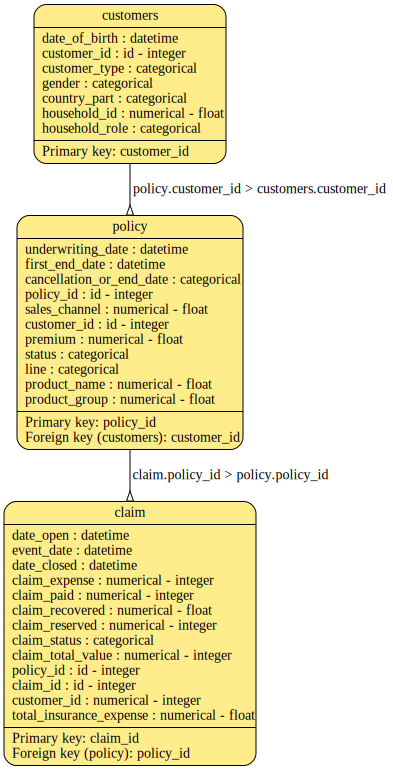

In [92]:
metadata.visualize()

In [104]:
metadata_name = '../models/zurich-sdv-1.0-metadata.json'
# export metadata to json
metadata.to_json(metadata_name)

# load metadata from json
# loaded = Metadata(metadata_name)

## CREATE HMA1 MODEL

In [96]:
display_tables(tables)

In [97]:
for name, table in tables.items():
    print(name, table.shape)

customers (509, 7)
policy (949, 11)
claim (162, 13)


In [100]:
# fit model
model = HMA1(metadata=metadata)
model.fit(tables)

/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column '__claim__policy_id__covariance__0__0'. Data will not be rounded.
  warnings.warn(
/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column '__claim__policy_id__covariance__2__0'. Data will not be rounded.
  warnings.warn(
/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column '__claim__policy_id__covariance__2__1'. Data will not be rounded.
  warnings.warn(
/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column '__claim__policy_id__covariance__3__0'. Data wi

In [103]:
# export model
model_name = '../models/zurich-sdv-1.0.pkl'
model.save(model_name)

In [106]:
### Generate synthetic data
synthetic_data = model.sample()

/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/sdv/relational/base.py:127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  primary_key_values = pd.Series([x for i, x in zip(range(num_rows), generator)])
/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/sdv/relational/base.py:127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  primary_key_values = pd.Series([x for i, x in zip(range(num_rows), generator)])
/Users/martinjurkovic/.pyenv/versions/3.8.12/envs/ds_project/lib/python3.8/site-packages/sdv/relational/base.py:127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  

In [108]:
synthetic_data['customers'].to_csv('../data/zurich_synthetic/1.0-customers.csv', index=False)
synthetic_data['policy'].to_csv('../data/zurich_synthetic/1.0-policy.csv', index=False)
synthetic_data['claim'].to_csv('../data/zurich_synthetic/1.0-claim.csv', index=False)

In [110]:
display_tables(synthetic_data)

In [112]:
for name, table in synthetic_data.items():
    print(name, table.shape)

customers (509, 7)
policy (2332, 11)
claim (786, 13)
